## Imports

In [153]:
import cv2
import json
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pprint
import itertools

## Constants

In [126]:
feature_location_json = Path('../config/FeatureLocation.json')
chip_location_json = Path('../Label_templates/Chip_map_list.json')

image_path = Path('/Volumes/krauss/Lisa/GMR/Array/250325/loc1_1/Pos0/img_000000000_Default_000.tif')
image_path = Path('/Volumes/krauss/Callum/03_Data/17_array_testing/ethanol_full_array_test_240425_flipped/image_20250424_161414.png')

## Outline

1. ☑ Load user feature location JSON file

2. ☑ Calculate the scale factor and image angle using the user feature location

3. ☑ Load the chip map JSON file and extract the labels location

4. ☑ Calculate the scale factor and image angle using the chip map

5. ☑ Rotate the image and user feature locations using calculated angle

6. ☑ Load template image and scale according to the scale factor

7. ☑ Find the location of the template in the image using cv2.matchTemplate

8. ☑ Display the results of the template matching on the image

9. ☑ Calculate some FOM values based on the template matching results

10. ☐ If matching FOM is below some threshold, attempt to match with a different technigue

11. ☐ Comparem matching results, if one is better, use that one

12. ☐ Calculate chip map transformation to match image

13. ☐ Save list of ROIs (i.e. grating locations) to a JSON file using transformation

☐ Unchecked
☑ Checked

## Load user feature locations from JSON file and populate 'user_chip_mapping' dictionary

In [172]:
def load_json(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{file_path}'. Check the file format.")
        return None
    except Exception as e:
        print(f'An unexpected error occurred: {e}')
        return None


In [173]:
def load_user_feature_locations(file_path):
    user_raw_data = load_json(file_path)
    user_chip_mapping = {}
    if user_raw_data:
        user_chip_mapping['chip_type'] = user_raw_data.get('chip_type', None)
        features = []
        for feature in user_raw_data.get('features', []):
            label_name = feature.get('label')
            feature_location = feature.get('feature_location')
            if label_name:
                features.append({
                    'label': label_name,
                    'user_location': feature_location
                })
        user_chip_mapping['features'] = features
    else:
        print("[ERROR] No valid user 'FeatureLocation.json' to load.")
    return user_chip_mapping

user_chip_mapping = load_user_feature_locations(feature_location_json)

if user_chip_mapping:
    print("[INFO] User 'FeatureLocation.json' loaded successfully:")
    pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
    pp.pprint(user_chip_mapping)


[INFO] User 'FeatureLocation.json' loaded successfully:
{   'chip_type': 'IMECII_2',
    'features': [   {'label': '2-Large', 'user_location': [1674, 6234]},
                    {'label': 'B-Left', 'user_location': [1320, 5022]},
                    {'label': 'C-Left', 'user_location': [1296, 3588]},
                    {'label': 'D-Left', 'user_location': [1254, 2178]},
                    {'label': 'E-Left', 'user_location': [1206, 768]}]}


## Load chip map locations from JSON and update 'user_chip_map' dictionary

In [174]:
def get_type_of_chip(chip_type, all_chip_mappings):
    for chip_mapping in all_chip_mappings:
        chip_name_label = chip_mapping.get('chip_type', None)
        if chip_name_label == chip_type:
            return chip_mapping
    return None

def get_location_from_label(label, chip_mapping):
    for chip_label in chip_mapping.get('labels'):
        if chip_label.get('label') == label:
            return chip_label.get('label_origin', None)
    return None

def get_user_label_locations_from_chip_map(chip_mapping, user_chip_mapping):
    user_features = user_chip_mapping.get('features', None)
    if user_features:
        for idx, user_feature in enumerate(user_features):
            label = user_feature.get('label')
            feature_location = get_location_from_label(label, chip_mapping)
            user_chip_mapping['features'][idx]['chip_location'] = feature_location
        return user_chip_mapping
    return None

def load_chip_feature_locations(file_path, user_chip_mapping):
    chip_raw_data = load_json(file_path)
    chip_type = user_chip_mapping.get('chip_type')
    chip_mapping = get_type_of_chip(chip_type, chip_raw_data)
    if chip_mapping:
        return get_user_label_locations_from_chip_map(chip_mapping, user_chip_mapping)
    return None

user_chip_mapping = load_chip_feature_locations(chip_location_json, user_chip_mapping)
if user_chip_mapping:
    print('[INFO] User data updated successfully:')
    pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
    pp.pprint(user_chip_mapping)
else:
    print('[ERROR] Something went wrong')

[INFO] User data updated successfully:
{   'chip_type': 'IMECII_2',
    'features': [   {   'chip_location': [-2300, 1500],
                        'label': '2-Large',
                        'user_location': [1674, 6234]},
                    {   'chip_location': [-2312, 960],
                        'label': 'B-Left',
                        'user_location': [1320, 5022]},
                    {   'chip_location': [-2312, -40],
                        'label': 'C-Left',
                        'user_location': [1296, 3588]},
                    {   'chip_location': [-2312, -1040],
                        'label': 'D-Left',
                        'user_location': [1254, 2178]},
                    {   'chip_location': [-2312, -2040],
                        'label': 'E-Left',
                        'user_location': [1206, 768]}]}


## Calculate the rotation angle

In [209]:
def angle_between_points(v1, v2):
    """Calculates the signed angle in degrees between the line connecting two vectors
    and the positive x-axis.

    Args:
        v1: (x1, y1)
        v2: (x2, y2)

    Returns:
        Angle in degrees, positive for counter-clockwise rotation from the
        positive x-axis to the line segment from point1 to point2.
    """
    x1, y1 = v1
    x2, y2 = v2

    dx = x2 - x1
    dy = y2 - y1

    return math.degrees(math.atan2(dy, dx))  # Angle relative to positive x-axis


def chip_rotation_angle(user_chip_mapping, key='user_location'):
    locations = [a[key] for a in user_chip_mapping['features']]
    chip_locations = [a['chip_location'] for a in user_chip_mapping['features']]

    combination_idxs = list(itertools.combinations(range(len(locations)), 2))

    location_combinations = [(locations[a], locations[b]) for (a, b) in combination_idxs]
    chip_location_combinations = [(chip_locations[a], chip_locations[b]) for (a, b) in combination_idxs]

    angles = [angle_between_points(a, b) for (a, b) in location_combinations]
    chip_angles = [angle_between_points(a, b) for (a, b) in chip_location_combinations]

    rotation_angles = [a - b for a, b in zip(chip_angles, angles)]

    rotation_angle = np.quantile(rotation_angles, 0.5)

    user_chip_mapping[f'{key}_all_rotation_angles'] = angles
    user_chip_mapping['chip_location_all_rotation_angles'] = chip_angles

    if 'refined' in key:
        rotation_angle = user_chip_mapping['rotation_angle'] + rotation_angle

    user_chip_mapping[f'{key}_rotation_angle'] = rotation_angle
    user_chip_mapping['rotation_angle'] = rotation_angle

    return user_chip_mapping, rotation_angle


user_chip_mapping, _ = chip_rotation_angle(user_chip_mapping, key='user_location')
if user_chip_mapping:
    print('[INFO] User data updated successfully:')
    pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
    pp.pprint(user_chip_mapping)


[INFO] User data updated successfully:
{   'chip_location_all_rotation_angles': [   -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0],
    'chip_type': 'IMECII_2',
    'features': [   {   'chip_location': [-2312, 960],
                        'label': 'B-Left',
                        'label_locating_success': True,
                        'match_quality': np.float32(1.5576564),
                        'refined_location': [1247, 4873],
                        'user_location': [1320, 5022]},
                    {   'chip_location': [-2312, -40],
                        'label': 'C-Left',
                        'label_locating_success': True,
                        'match_quality': np.float32(2.0562563),
                        'refined_location': [1249, 3459],
           

## Calculate the scale factor

In [208]:
def calculate_distance(v1, v2):
    """Calculates the Euclidean distance between two points in 2D space.

    Args:
      v1: A tuple or list representing the first point (x1, y1).
      v1: A tuple or list representing the second point (x2, y2).

    Returns:
      The Euclidean distance between the two points.
    """
    x1, y1 = v1
    x2, y2 = v2

    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def user_chip_scale_factor(user_chip_mapping, key='user_location'):
    locations = [a[key] for a in user_chip_mapping['features']]
    chip_locations = [a['chip_location'] for a in user_chip_mapping['features']]

    combination_idxs = list(itertools.combinations(range(len(locations)), 2))

    location_combinations = [(locations[a], locations[b]) for (a, b) in combination_idxs]
    chip_location_combinations = [(chip_locations[a], chip_locations[b]) for (a, b) in combination_idxs]

    distances = [calculate_distance(a, b) for (a, b) in location_combinations]
    chip_distances = [calculate_distance(a, b) for (a, b) in chip_location_combinations]

    scale_factors = [a / b for a, b in zip(distances, chip_distances)]

    user_chip_mapping[f'{key}_all_scale_factors'] = scale_factors

    scale_factor = np.quantile(scale_factors, 0.5)

    user_chip_mapping[f'{key}_scale_factor'] = scale_factor
    user_chip_mapping['scale_factor'] = scale_factor

    # print(f'Distance between user features: {user_distance:.2f} pixels')
    # print(f'Distance between map features: {chip_distance:.2f} microns')
    # print(f'Scale factor: {scale_factor:.2f} pixels/micron')
    return user_chip_mapping, scale_factor

user_chip_mapping, scale_factor = user_chip_scale_factor(user_chip_mapping, key='user_location')
if user_chip_mapping:
    print(f'{scale_factor = }')
    print('User data updated successfully:')
    pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
    pp.pprint(user_chip_mapping)


scale_factor = np.float64(1.4146629305816565)
User data updated successfully:
{   'chip_location_all_rotation_angles': [   -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0],
    'chip_type': 'IMECII_2',
    'features': [   {   'chip_location': [-2312, 960],
                        'label': 'B-Left',
                        'label_locating_success': True,
                        'match_quality': np.float32(1.5576564),
                        'refined_location': [1247, 4873],
                        'user_location': [1320, 5022]},
                    {   'chip_location': [-2312, -40],
                        'label': 'C-Left',
                        'label_locating_success': True,
                        'match_quality': np.float32(2.0562563),
                        'refin

## Rotate the image and user feature locations using calculated angle

In [178]:
def rotate_image(image, rotation_angle):
    """
    Rotates an image based on corresponding feature points.

    Args:
        image: The input image (OpenCV format).
        rotation_angle: rotation angle

    Returns:
        rotated_image: The rotated image
    """

    # Calculate the center of rotation (midpoint of the image points)
    h, w = image.shape
    center = (w / 2, h / 2)

    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Apply the rotation and scaling
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

    return rotated_image


def rotate_user_feature_locations(user_location, image_center, rotation_angle):
    """Rotates a point around a center by a given angle in degrees.

    Args:
        user_location: The point to rotate (x, y).
        image_center: The center of rotation (x, y).
        rotation_angle: rotation angle

    Returns:
        The rotated point (x, y).
    """
    x, y = user_location
    cx, cy = image_center
    angle_rad = math.radians(rotation_angle)

    rotated_x = cx + (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad)
    rotated_y = cy + (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad)
    return [int(rotated_x), int(rotated_y)]

## Load template image and scale according to the scale factor

In [179]:
def load_template(template_path):
    """
    Loads a template image from the specified path.

    Args:
        template_path: Path to the template image.

    Returns:
        The loaded template image.
    """
    try:
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        if template is None:
            raise ValueError(f"Could not load image at {template_path}")
        return template
    except Exception as e:
        print(f"Error loading template: {e}")
        return None

In [180]:
def scale_template(template, scale_factor):
    """Scales a template image by a given factor.

    Args:
        template: The template image (OpenCV format).
        scale_factor: The scaling factor.

    Returns:
        The scaled template image.
    """
    new_size = (int(template.shape[1] * scale_factor), int(template.shape[0] * scale_factor))
    scaled_template = cv2.resize(template, new_size, interpolation=cv2.INTER_LINEAR)
    return scaled_template

## Find the location of the template in the image using cv2.matchTemplate

In [197]:
def get_template_image_from_label(chip_type, label):
    template_path = Path(f'../Label_templates/IMECII/{chip_type}/{label}.png')
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        print(f"Error: Could not load template image {template_path}.")
        return None
    return template


def refine_feature_locations(image, user_chip_mapping):
    """Refines the location of a feature using template matching,
    accounting for image rotation.

    Args:
        image: The image to search in (already rotated).
        initial_location: The initial (approximate) location of the feature (x, y) in the *original* image coordinates.
        template: The template image of the feature.
        rotation_angle: The angle by which the image was rotated (in degrees, clockwise).
        image_center: The center of the rotation of the image.
        scale_factor: Scaling factor for matching template size to image size

    Returns:
        A tuple containing:
            - The refined location (x, y) in the rotated image coordinates.
            - The rotated initial location
            - The original initial location
        Returns (None, None, None) if template matching fails.
    """

    chip_type = user_chip_mapping.get('chip_type')
    rotation_angle = user_chip_mapping.get('rotation_angle', 0)
    scale_factor = user_chip_mapping.get('scale_factor', 1.0)
    image_center = (image.shape[1] / 2, image.shape[0] / 2)
    user_features = user_chip_mapping.get('features', None)

    if not user_features:
        return None

    for idx, f in enumerate(user_features):
        label = f.get('label')
        user_location = f.get('user_location')

        # Rotate the user location to match the rotated image
        rotated_user_location = rotate_user_feature_locations(user_location, image_center, rotation_angle)

        # Load template image
        template = get_template_image_from_label(chip_type, label)

        # Scale template to match image size
        template = scale_template(template, scale_factor)

        # Define a search window around the rotated initial location
        search_window_size = (template.shape[1] * 1.5, template.shape[0] * 1.5)
        x_start = max(0, int(rotated_user_location[0] - search_window_size[0] / 2))
        y_start = max(0, int(rotated_user_location[1] - search_window_size[1] / 2))
        x_end = min(image.shape[1], int(rotated_user_location[0] + search_window_size[0] / 2))
        y_end = min(image.shape[0], int(rotated_user_location[1] + search_window_size[1] / 2))

        search_window = image[y_start:y_end, x_start:x_end]

        # Pre-process the search window to match the template type
          # Sharpen the search window
        blurred = cv2.GaussianBlur(search_window, (25, 25), 0)
        sharpened_search_window = cv2.addWeighted(search_window, 1.5, blurred, -0.5, 0)

          # Binarise the search window to match the template
        _, binarized_search_window = cv2.threshold(sharpened_search_window, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        visualize_search_window_preprocessing(search_window, sharpened_search_window, binarized_search_window)

        # Perform template matching
        result = cv2.matchTemplate(binarized_search_window, template, cv2.TM_CCORR_NORMED)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Calculate a quality metric (e.g., peak-to-mean ratio)
        mean_val = np.mean(result)
        quality_metric = max_val / mean_val if mean_val > 0 else 0  # Avoid division by zero
        visualize_template_matching_result(search_window, result, max_loc, max_val, mean_val, quality_metric)

        if quality_metric > 1.5 and max_val > 0.5:  # Example threshold. Adjust as needed.
            refined_x = x_start + max_loc[0]
            refined_y = y_start + max_loc[1]
            user_chip_mapping['features'][idx]['refined_location'] = [refined_x, refined_y]
            user_chip_mapping['features'][idx]['match_quality'] = quality_metric  # Store the quality
            is_good_match = True
            user_chip_mapping['features'][idx]['label_locating_success'] = is_good_match
        else:
            refined_x = None
            refined_y = None
            user_chip_mapping['features'][idx]['refined_location'] = None
            user_chip_mapping['features'][idx]['match_quality'] = quality_metric
            is_good_match = False
            user_chip_mapping['features'][idx]['label_locating_success'] = is_good_match
    return user_chip_mapping, [refined_x, refined_y], template.shape


## Visualise results with matplotlib

In [136]:
def visualize_search_window_preprocessing(original_search_window, sharpened_search_window, binarized_search_window):
    """
    Visualizes the original, sharpened, and binarized search windows using Matplotlib.

    Args:
        original_search_window: The original search window image.
        sharpened_search_window: The sharpened search window image.
        binarized_search_window: The binarized search window image.
    """
    # Create a Matplotlib figure with three subplots in one row
    _, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns, adjust figure size as needed

    # Display the original search window in the first subplot
    axes[0].imshow(cv2.cvtColor(original_search_window, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    axes[0].set_title('Original Search Window')
    axes[0].axis('off')  # Turn off axis labels

    # Display the sharpened search window in the second subplot
    axes[1].imshow(cv2.cvtColor(sharpened_search_window, cv2.COLOR_BGR2RGB))  # Convert to RGB
    axes[1].set_title('Sharpened Search Window')
    axes[1].axis('off')

    # Display the binarized search window in the third subplot
    axes[2].imshow(cv2.cvtColor(binarized_search_window, cv2.COLOR_BGR2RGB))  # Otherwise, convert to RGB
    axes[2].set_title('Binarized Search Window')
    axes[2].axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

In [137]:
def visualize_template_matching_result(search_window, result, max_loc, max_val, mean_val, quality_metric):
    """
    Visualizes the search window and the template matching result with the
    location of the maximum match.

    Args:
        search_window: The image search window.
        result: The template matching result image.
        max_loc: The (x, y) location of the maximum value in the result.
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the search window
    ax1.imshow(cv2.cvtColor(search_window, cv2.COLOR_BGR2RGB))
    ax1.set_title('Search Window')
    circle1 = patches.Circle(max_loc, 5, color='red', fill=False)
    ax1.add_patch(circle1)

    # Display the template matching result
    ax2.imshow(result, cmap='gray')
    ax2.set_title(f'Template Matching Result\n{max_val =:.2f}\n{mean_val =:.2f}\n{quality_metric =:.2f}')
    circle2 = patches.Circle(max_loc, 5, color='red', fill=False)
    ax2.add_patch(circle2)

    plt.tight_layout()
    plt.show()

In [245]:
def visualize_features_with_matplotlib(rotated_image, chip_mapping, feature_shape, key='features'):
    """
    Visualizes user and refined feature locations on a rotated image using Matplotlib.

    Args:
        rotated_image: The rotated image (OpenCV format).
        chip_mapping: A dictionary containing feature information, including
            user and refined locations.  Assumed to have the same structure
            as the `user_features` variable in previous examples.
        feature_shape:  The shape (height, width) of the feature, needed to draw the rectangle.
    """

    # Convert the OpenCV image to RGB format for Matplotlib
    rotated_image_rgb = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)

    # Create a Matplotlib figure and axes
    _, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(rotated_image_rgb)  # Display the image

    if 'features' in key:
        features = chip_mapping.get(key, None)  # Get the features list.
    if 'gratings' in key:
        features = chip_mapping

    if features:
        for f in features:
            label = f.get('label')
            if 'features' in key:
                location = f.get('refined_location')
            if 'gratings' in key:
                location = f.get('grating_origin')

            if location:
                x, y = location
                # height, width = (10, 10)
                if feature_shape:
                    height, width = feature_shape  # Corrected order for Matplotlib
                else:
                    width = f.get('x-size')
                    height = f.get('y-size')

                rect = patches.Rectangle((x, y), width, height, linewidth=1,
                                         edgecolor='white', facecolor='none')
                ax.add_patch(rect)
                ax.annotate(label, location, color='white',
                            fontsize=8, ha='center', va='bottom')

    plt.title('Rotated Image with features highlighted')
    plt.show()  # Display the plot

## Calculate image offset from chip map

In [258]:
def calculate_chip_offset(user_chip_mapping):
    user_features = user_chip_mapping.get('features', None)
    scale_factor = user_chip_mapping.get('scale_factor', 1.0)

    if not user_features:
        return None

    x_offsets = []
    y_offsets = []
    for idx, f in enumerate(user_features):
        offset = [a - (b * scale_factor) for a, b in zip(f['refined_location'], f['chip_location'])]
        x_offsets.append(offset[0])
        y_offsets.append(offset[1])
        user_chip_mapping['features'][idx]['feature_offset'] = offset

    user_chip_mapping['offset'] = [np.quantile(x_offsets, 0.5), np.quantile(y_offsets, 0.5)]
    return user_chip_mapping

## Load and offset grating locations from chip map

In [259]:
def offset_and_scale_grating_data(grating_mapping, user_chip_mapping):
    offset = user_chip_mapping.get('offset', [None, None])
    scale_factor = user_chip_mapping['scale_factor']
    if offset:
        for idx, grating in enumerate(grating_mapping):
            offset_grating_origin = [int((a * scale_factor) + b) for a, b in zip(grating['grating_origin'], offset)]
            grating_mapping[idx]['grating_origin'] = offset_grating_origin
            grating_mapping[idx]['x-size'] = int(grating['x-size'] * scale_factor)
            grating_mapping[idx]['y-size'] = int(grating['y-size'] * scale_factor)
        return grating_mapping
    return None

def load_and_offset_grating_data(file_path, user_chip_mapping):
    chip_raw_data = load_json(file_path)
    chip_type = user_chip_mapping.get('chip_type')
    chip_mapping = get_type_of_chip(chip_type, chip_raw_data)
    if chip_mapping:
        raw_grating_mapping = chip_mapping.get('gratings', None)
    if raw_grating_mapping:
        return offset_and_scale_grating_data(raw_grating_mapping, user_chip_mapping)
    return None

chip_mapping = load_and_offset_grating_data(chip_location_json, user_chip_mapping)
if chip_mapping:
    print('[INFO] User data updated successfully:')
    pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
    pp.pprint(chip_mapping)
else:
    print('[ERROR] Something went wrong')

[INFO] User data updated successfully:
[   {   'grating_origin': [-6703, -779],
        'label': '001A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-5970, -779],
        'label': '002A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-5236, -779],
        'label': '003A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-4502, -779],
        'label': '004A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-3769, -779],
        'label': '005A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-3035, -779],
        'label': '006A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-2302, -779],
        'label': '007A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-6886, -1083],
        'label': '011A',
        'x-size': 352,
        'y-size': 289},
    {   'grating_origin': [-6153, -1083],
        'label

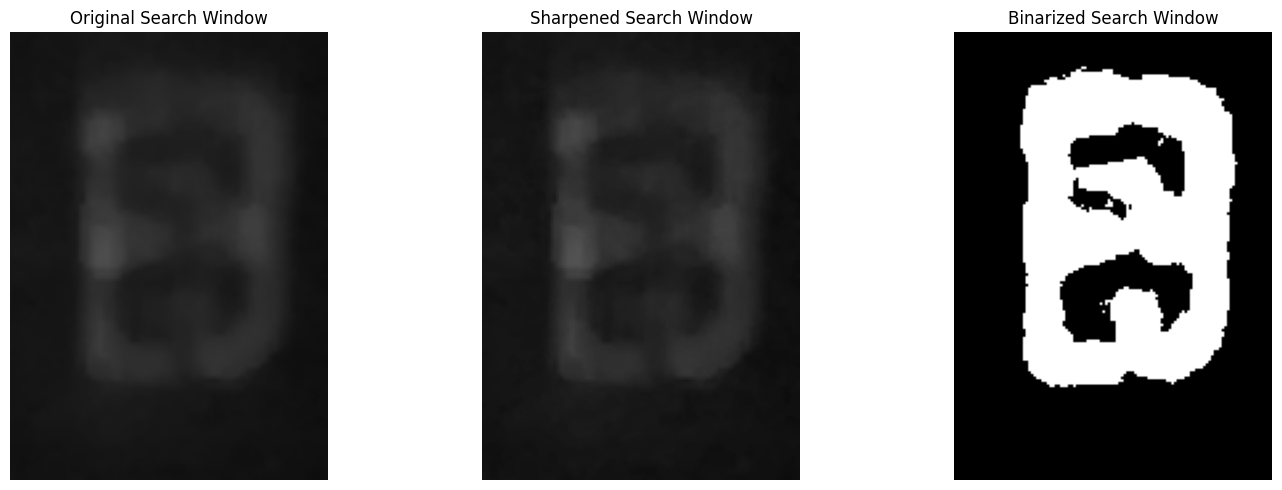

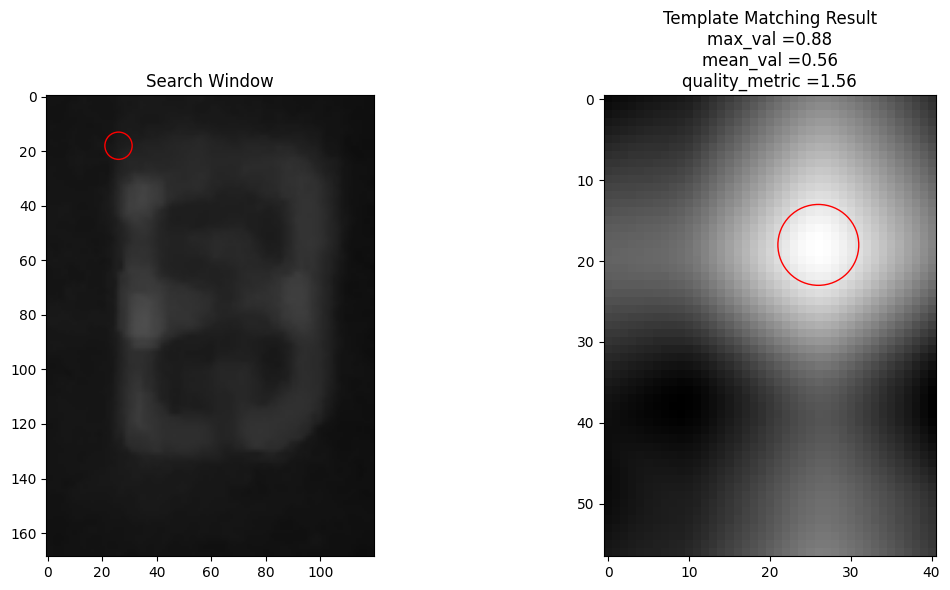

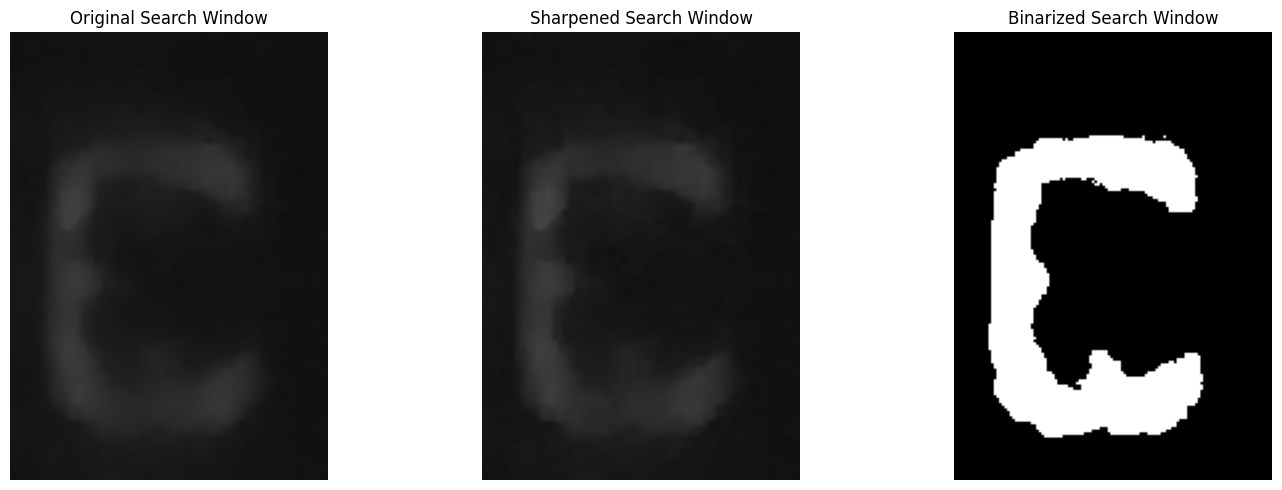

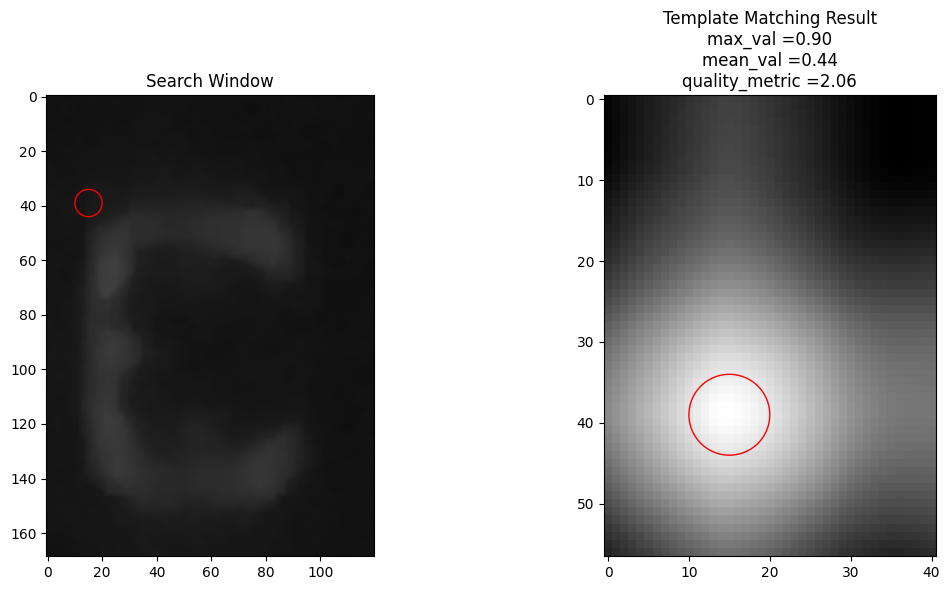

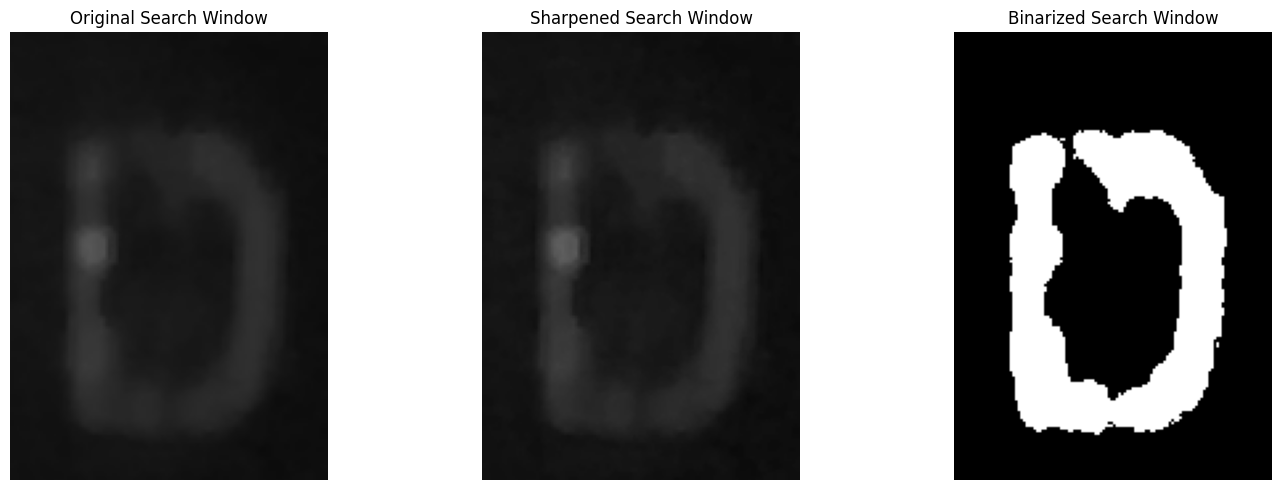

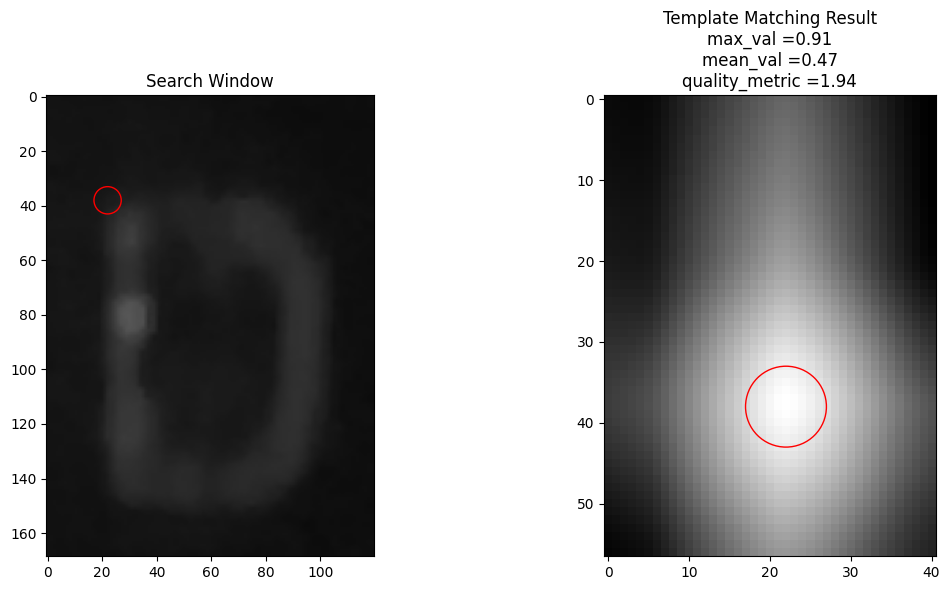

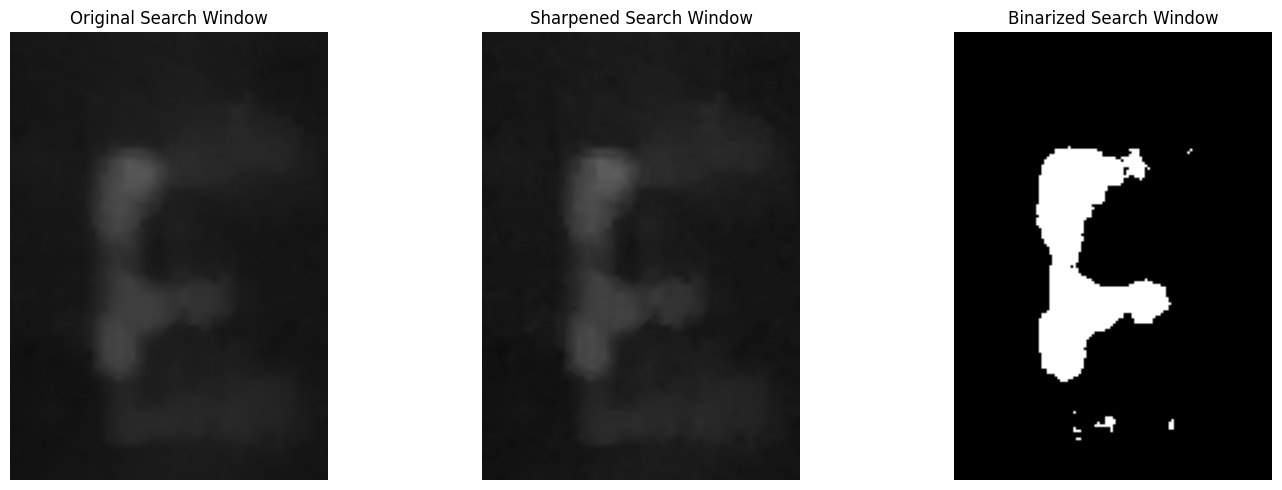

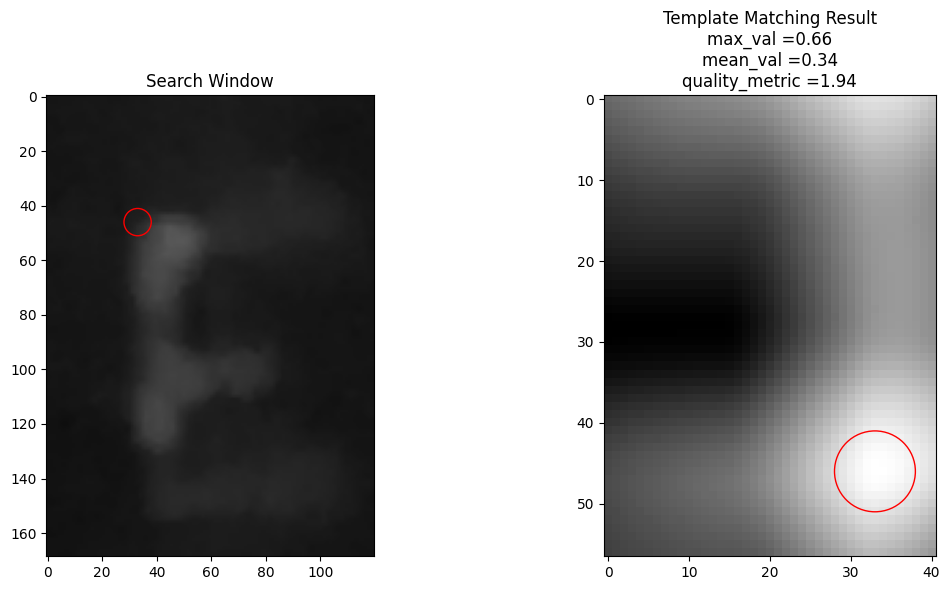

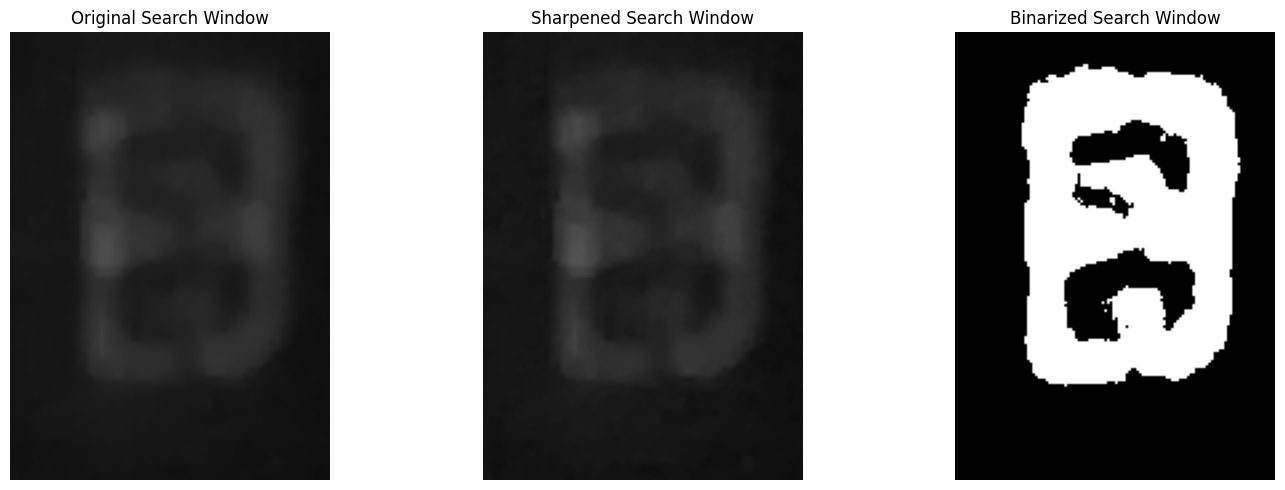

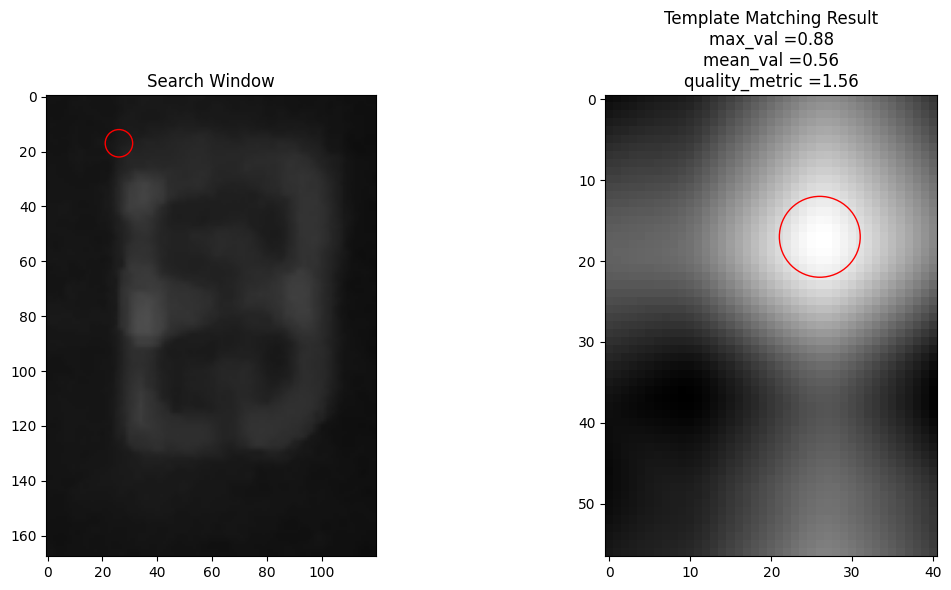

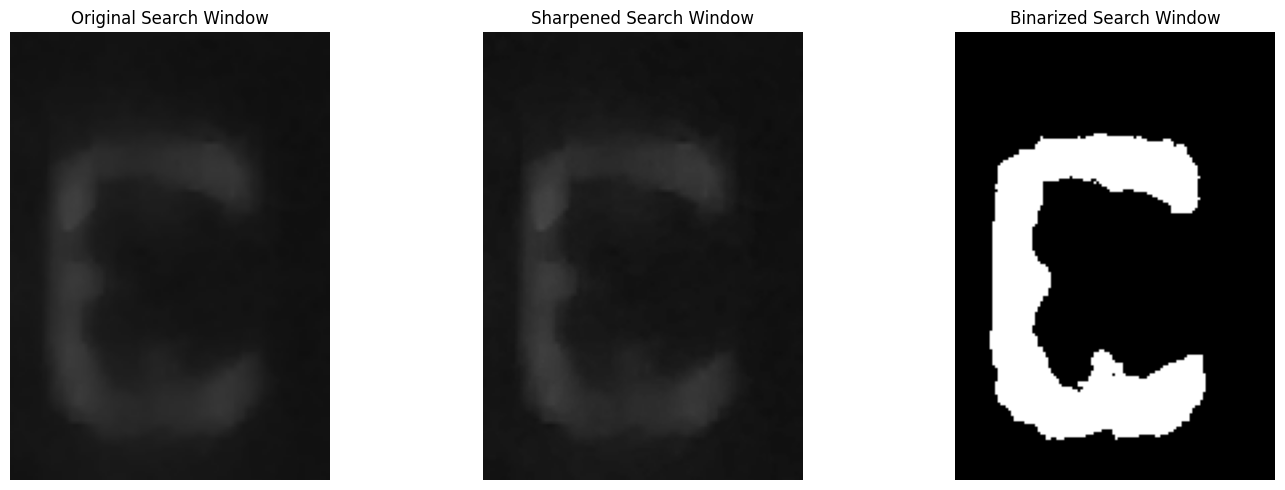

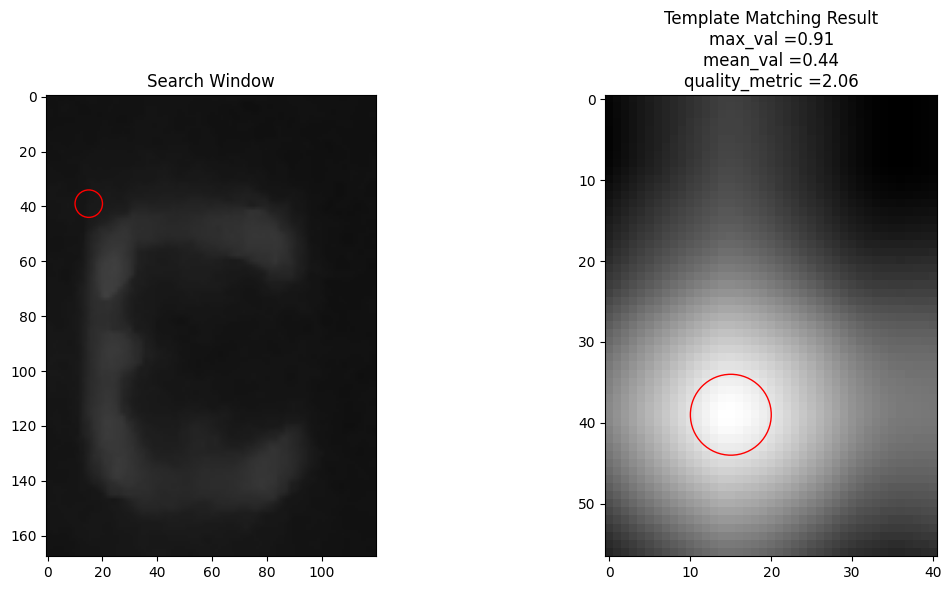

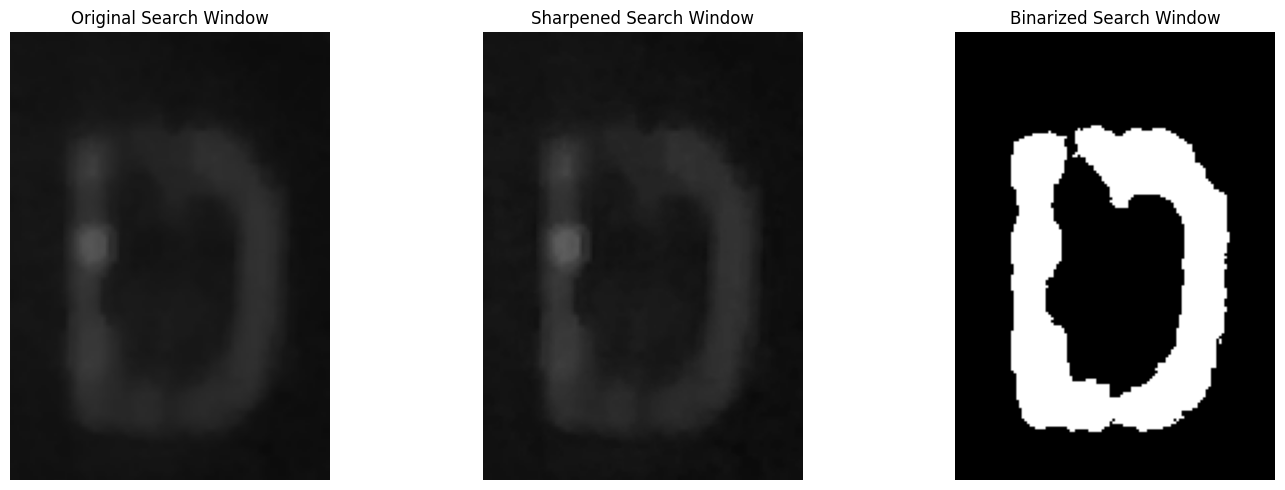

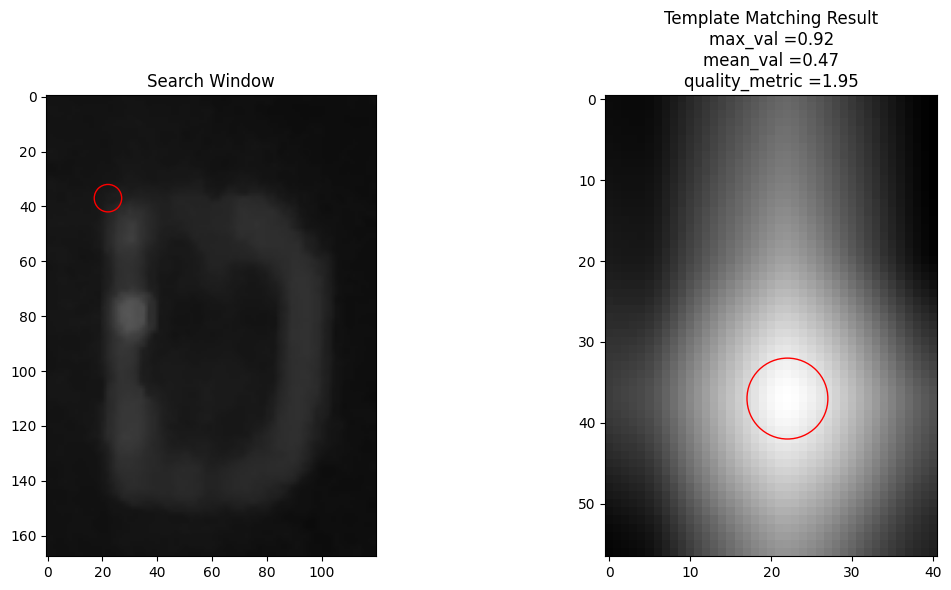

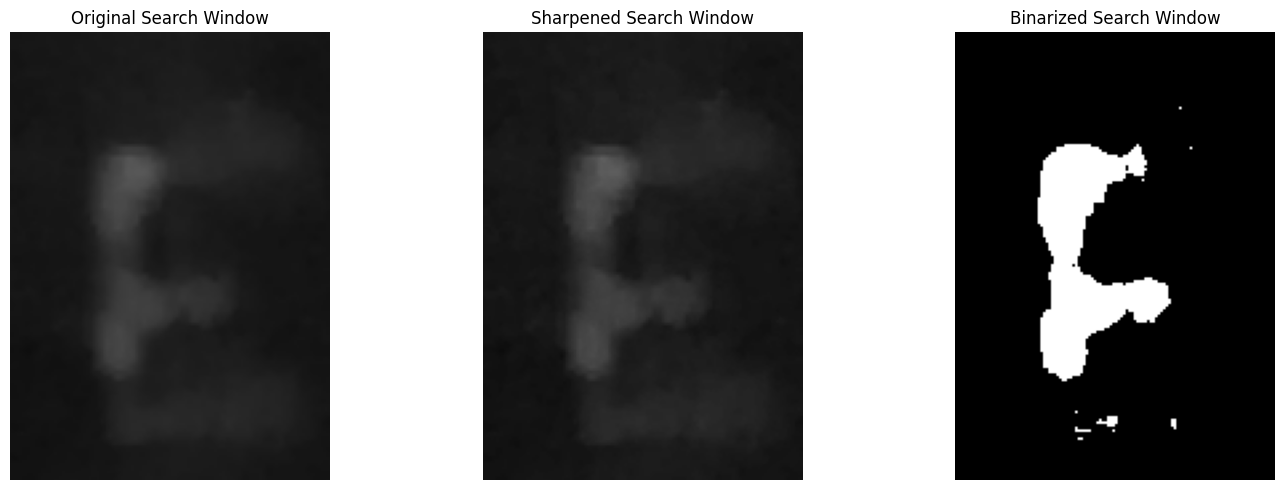

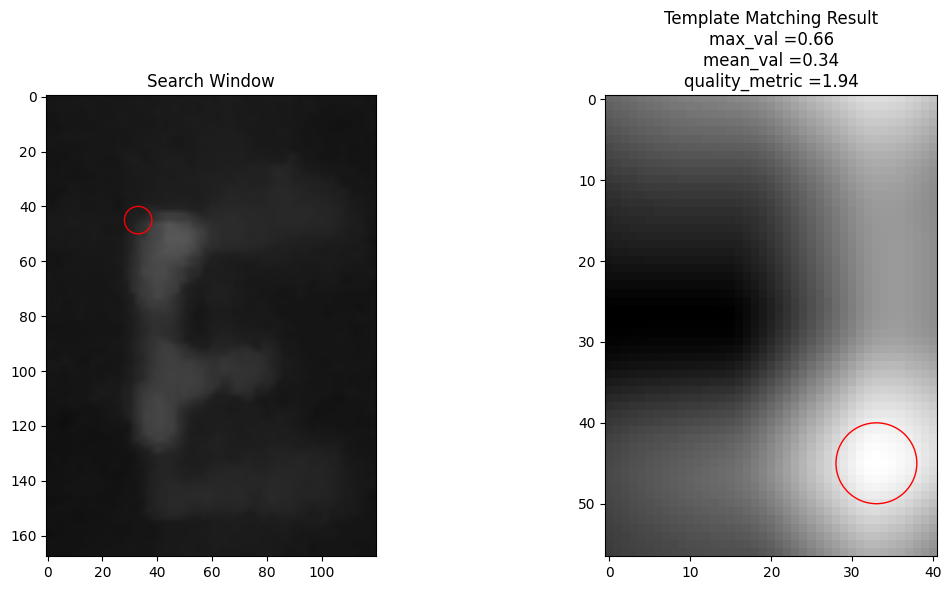

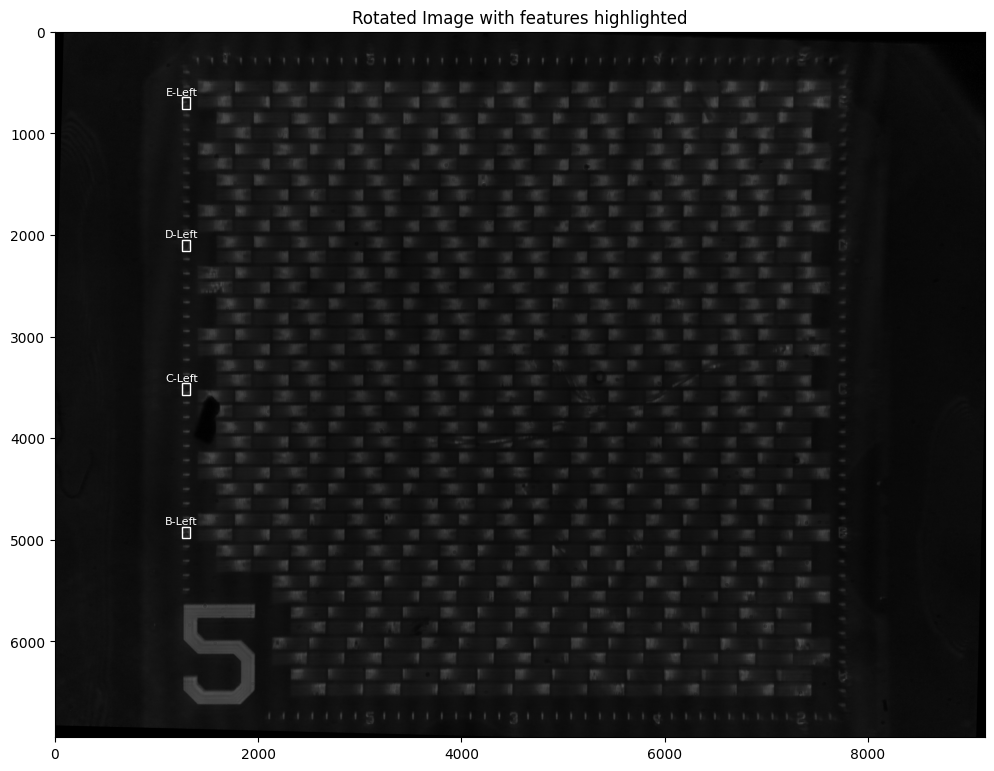

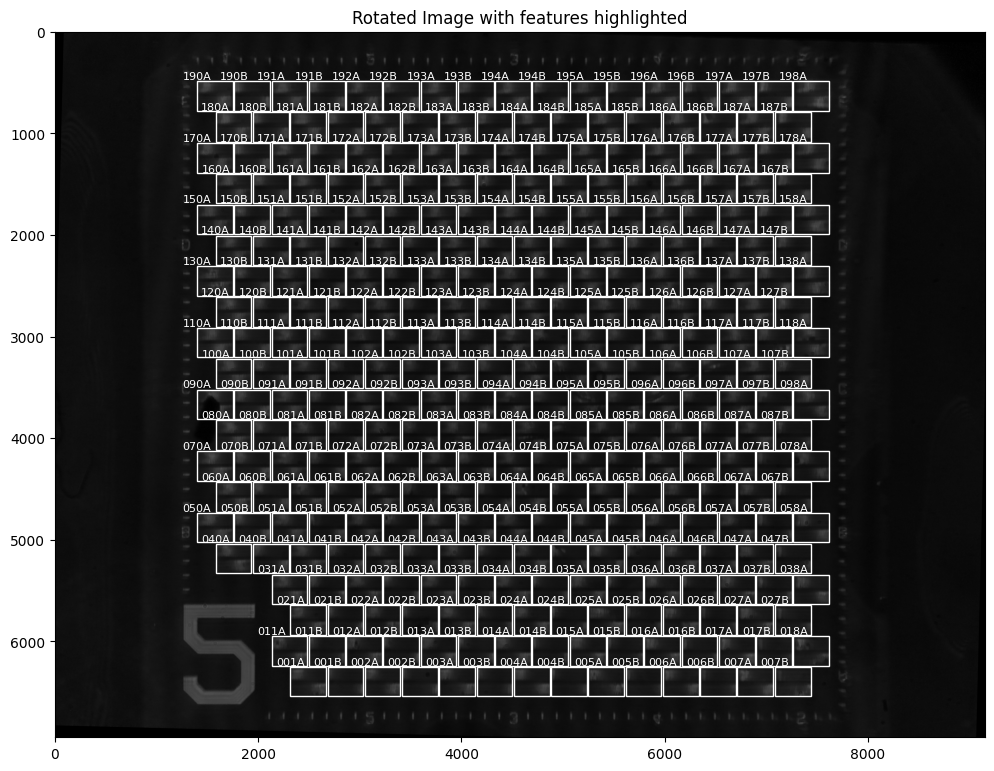

User chip mapping:
{   'chip_location_all_rotation_angles': [   -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0,
                                             -90.0],
    'chip_type': 'IMECII_2',
    'features': [   {   'chip_location': [-2312, 960],
                        'feature_offset': [   np.float64(4508.475584075422),
                                              np.float64(3517.754082736849)],
                        'label': 'B-Left',
                        'label_locating_success': True,
                        'match_quality': np.float32(1.5597569),
                        'refined_location': [1247, 4872],
                        'user_location': [1320, 5022]},
                    {   'chip_location': [-2312, -40],
                        'feature_offset': [   np.float64(4510.475584075422),
                    

In [ ]:
"""Main function to perform image alignment and feature localization."""
# 1. Load data
feature_location_json = Path('../config/FeatureLocation.json')
chip_location_json = Path('../Label_templates/Chip_map_list.json')

image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
image = cv2.normalize(
        image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U # type: ignore
    )  # Normalize to 8-bit range (0-255)
if len(image.shape) > 2:  # Check if the image has more than one channel (i.e., it's not already greyscale)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if image is None:
    print(f"[ERROR] Could not load image from {image_path}")
    exit(1)

user_chip_mapping = load_user_feature_locations(feature_location_json)
user_chip_mapping = load_chip_feature_locations(chip_location_json, user_chip_mapping)

# 2. Calculate angle and scale according to user's input
user_chip_mapping, initial_rotation_angle = chip_rotation_angle(user_chip_mapping, key='user_location')
user_chip_mapping, _ = user_chip_scale_factor(user_chip_mapping)

# 3. Rotate image using user angle
rotated_image = rotate_image(image, -initial_rotation_angle)
if rotated_image is None:
    print("[ERROR] Image rotation and scaling failed.")
    exit(1)

# 4. Refine feature locations using template matching
user_chip_mapping, refined_locations, _ = refine_feature_locations(rotated_image, user_chip_mapping)

if not refined_locations:
    print(f'[ERROR] Label locating failed')
    exit(1)

# 5. Calculate rotation-angle / scale-factor of image from locatedd the image features (not from user input locations)
user_chip_mapping, refined_rotation_angle = chip_rotation_angle(user_chip_mapping, key='refined_location')
# user_chip_mapping['rotation_angle'] = initial_rotation_angle + refined_rotation_angle
user_chip_mapping, refined_scale_factor = user_chip_scale_factor(user_chip_mapping, key='refined_location')

# 6. Rotate image by refined rotation angle
rotated_image = rotate_image(image, -user_chip_mapping['rotation_angle'])
if rotated_image is None:
    print("[ERROR] Image rotation and scaling failed.")
    exit(1)

# 6. Refine feature locations again with new rotation-angle / scale-factor using template matching
user_chip_mapping, refined_locations, template_shape = refine_feature_locations(rotated_image, user_chip_mapping)

# 7. Calculate offset between image and chip-map
user_chip_mapping = calculate_chip_offset(user_chip_mapping)

# 8. Load and offset grating locations
grating_locations = load_and_offset_grating_data(chip_location_json, user_chip_mapping)

# 9.. Visualise feature location results
visualize_features_with_matplotlib(rotated_image, user_chip_mapping, template_shape, key='features')

# 10. Visualise grating location results
visualize_features_with_matplotlib(rotated_image, grating_locations, None, key='gratings')

# 11. Display results
pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter object
print('User chip mapping:')
pp.pprint(user_chip_mapping)

## Validate auto-label locating results

In [212]:
keys = [
        'user_location_all_rotation_angles',
        'refined_location_all_rotation_angles',
        'user_location_all_scale_factors',
        'refined_location_all_scale_factors',
        ]

for k in keys:
    temp = user_chip_mapping.get(k)
    print(f'{k} : STD : {np.std(temp)}')

print('')

for k in keys:
    temp = user_chip_mapping.get(k)
    print(f'{k} : MEDIAN : {np.quantile(temp, 0.5)}')
    print(f'{k} : MEAN : {np.mean(temp)}')


user_location_all_rotation_angles : STD : 0.3316124767119831
refined_location_all_rotation_angles : STD : 0.039607640428723154
user_location_all_scale_factors : STD : 0.008571800561907645
refined_location_all_scale_factors : STD : 0.0035086555864888014

user_location_all_rotation_angles : MEDIAN : -91.62062040660331
user_location_all_rotation_angles : MEAN : -91.55119944400421
refined_location_all_rotation_angles : MEDIAN : -89.83076019194392
refined_location_all_rotation_angles : MEAN : -89.82507029181649
user_location_all_scale_factors : MEDIAN : 1.4146629305816565
user_location_all_scale_factors : MEAN : 1.4178754732233931
refined_location_all_scale_factors : MEDIAN : 1.4106728304824492
refined_location_all_scale_factors : MEAN : 1.4095624680634102
